## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
prop_images = []

default_height, default_width = 720, 1280

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True and gray.shape == (default_height, default_width):
        objpoints.append(objp)
        imgpoints.append(corners)
        prop_images.append(img)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        
cv2.destroyAllWindows()

# Next, apply a distortion correction to the test images

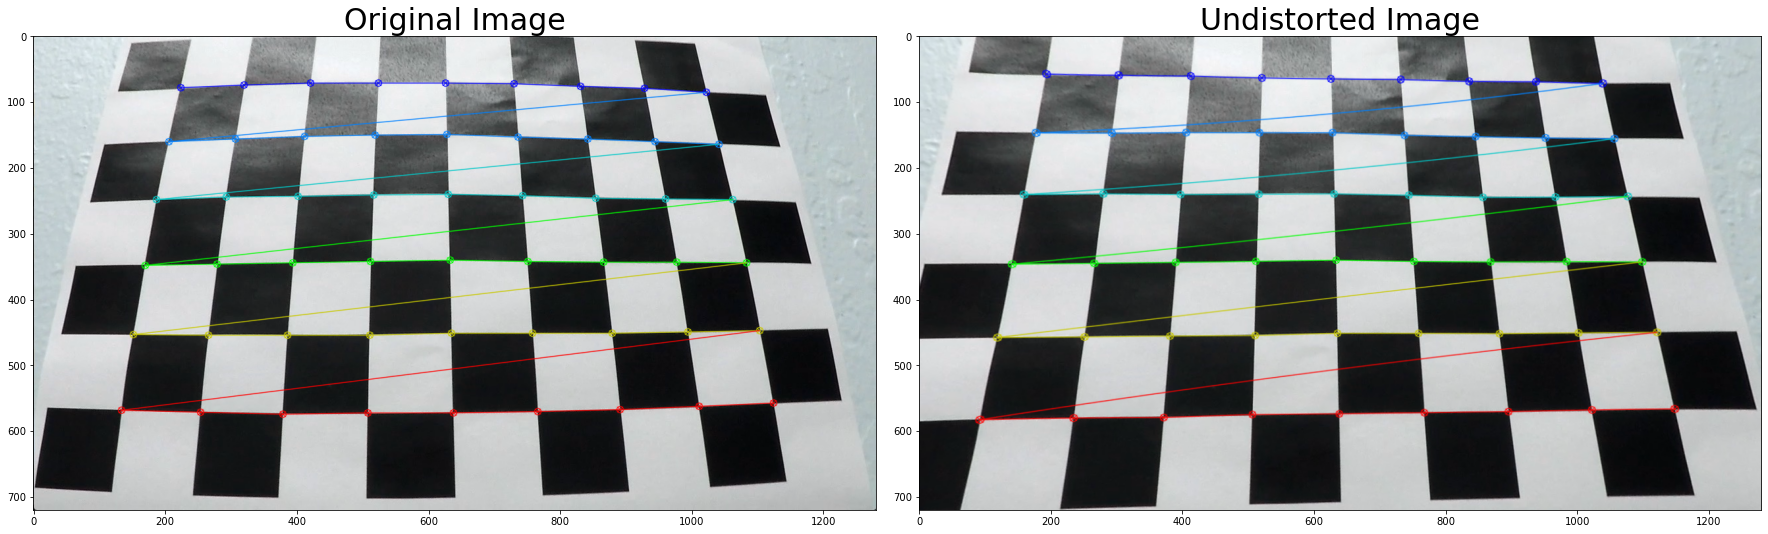

In [3]:
import random
%matplotlib inline

test_image_dist = random.choice(prop_images)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (default_width, default_height), None, None)
test_image_undist = cv2.undistort(test_image_dist, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_dist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Test undistortion on a non-calibration image

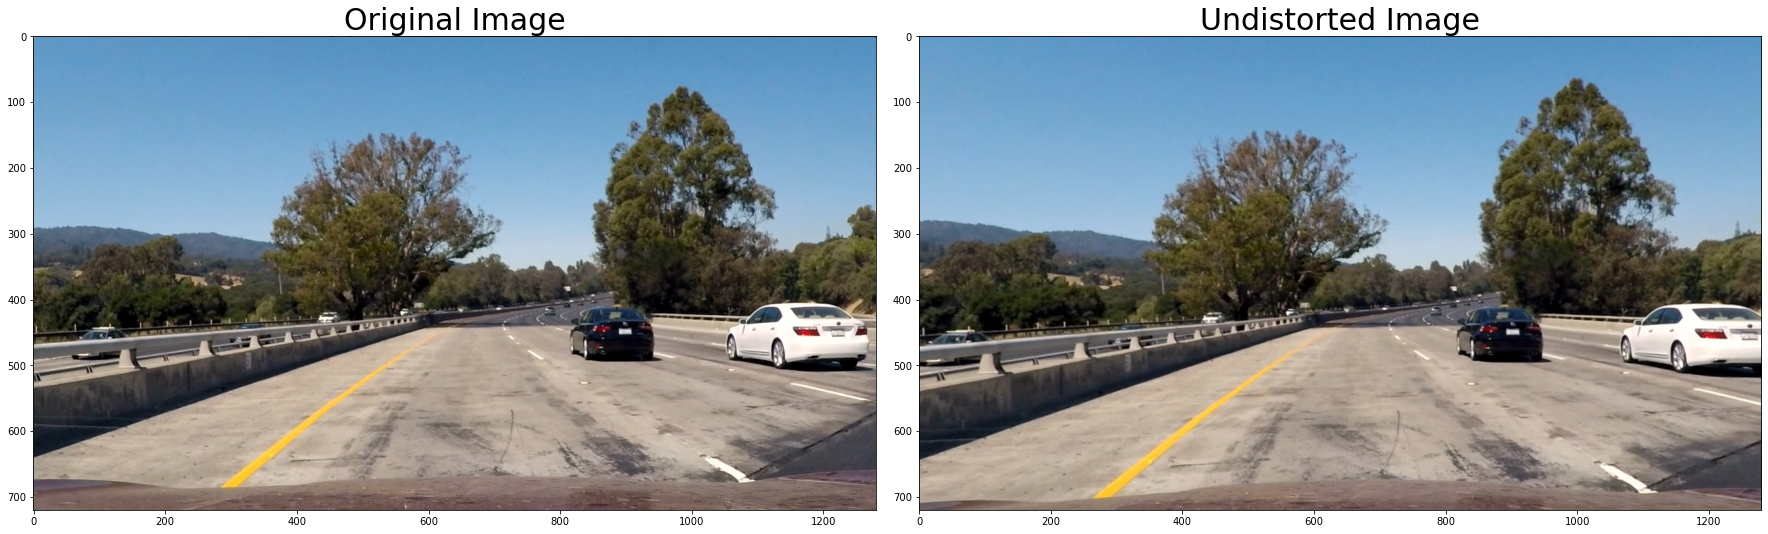

In [4]:
import matplotlib.image as mpimage

test_images = glob.glob('test_images/test*.jpg')
test_image_dist = mpimage.imread(random.choice(test_images))

assert test_image_dist.shape[:2] == (default_height, default_width)

test_image_undist = cv2.undistort(test_image_dist, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_dist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Use color transforms and gradients to create a thresholded binary image

Text(0.5, 1.0, 'Saturation')

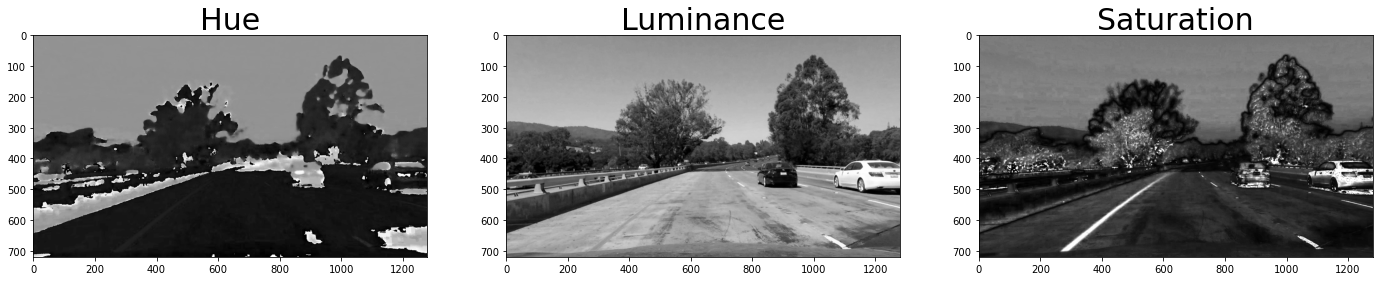

In [5]:
img = np.copy(test_image_undist)

img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = img_hls[:,:,0]
L = img_hls[:,:,1]
S = img_hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(H, cmap='gray')
ax1.set_title('Hue', fontsize=30)
ax2.imshow(L, cmap='gray')
ax2.set_title('Luminance', fontsize=30)
ax3.imshow(S, cmap='gray')
ax3.set_title('Saturation', fontsize=30)

We see that saturation is best at picking up lane markings

# Compare different Sobel gradient thresholds on each channel + original image

Text(0.5, 1.0, 'Sobel Mag - Saturation')

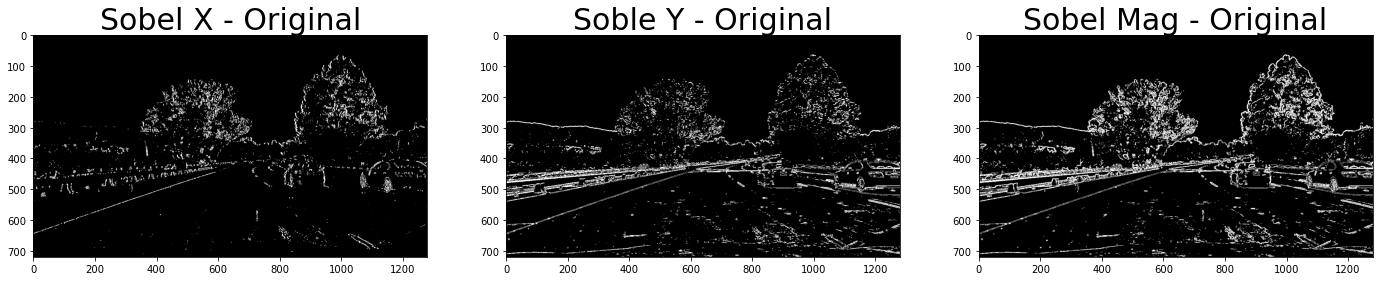

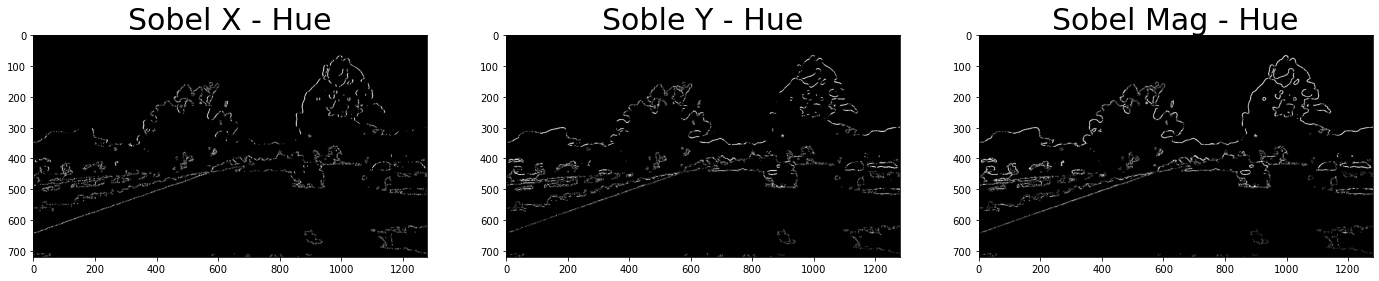

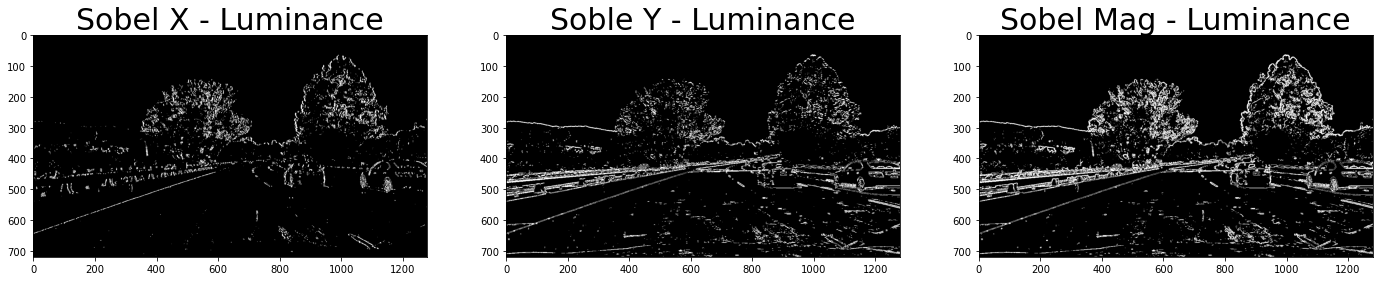

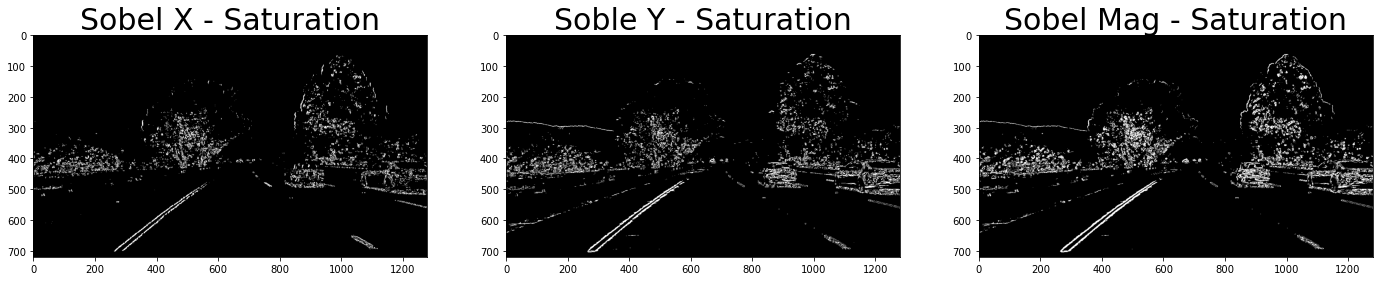

In [6]:
# applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient == 'x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# applies Sobel x and y, then computes the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    mag = np.sqrt(cv2.Sobel(gray, cv2.CV_64F, 1, 0)**2 + cv2.Sobel(gray, cv2.CV_64F, 0, 1)**2)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

thresh_min, thresh_max = 30, 100

gray_img_sobelx = abs_sobel_thresh(img, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(img, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(img, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Original', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Original', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Original', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(H, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(H, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(H, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Hue', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Hue', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Hue', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(L, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(L, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(L, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Luminance', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Luminance', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Luminance', fontsize=30)

gray_img_sobelx = abs_sobel_thresh(S, orient='x', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobely = abs_sobel_thresh(S, orient='y', thresh_min=thresh_min, thresh_max=thresh_max)
gray_img_sobelmag = mag_thresh(S, mag_thresh=(thresh_min, thresh_max))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(gray_img_sobelx, cmap="gray")
ax1.set_title('Sobel X - Saturation', fontsize=30)
ax2.imshow(gray_img_sobely, cmap="gray")
ax2.set_title('Soble Y - Saturation', fontsize=30)
ax3.imshow(gray_img_sobelmag, cmap="gray")
ax3.set_title('Sobel Mag - Saturation', fontsize=30)


Maybe a combination of sobel X-gradient on the original grayscale image and sobel magitude-gradient on the saturation channel will work 

# Compare color thresholding on channels

Text(0.5, 1.0, 'Saturation binary')

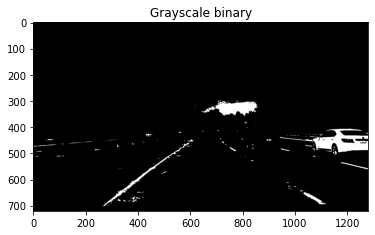

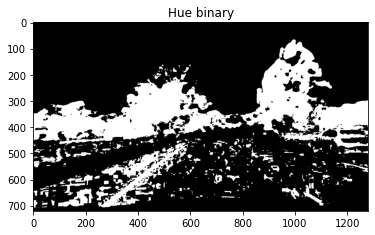

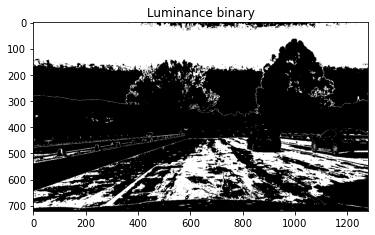

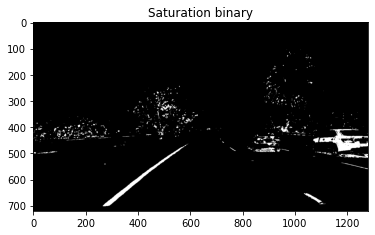

In [7]:
def binary_thresh(img, thresh_min=0, thresh_max=255):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np.copy(img)
    binary = np.zeros_like(gray)
    binary[(gray > thresh_min) & (gray <= thresh_max)] = 1
    return binary

gray_binary = binary_thresh(img, thresh_min=200, thresh_max=255)
fig, ax = plt.subplots()
ax.imshow(gray_binary, cmap="gray")
ax.set_title("Grayscale binary")

hue_binary = binary_thresh(H, thresh_min=15, thresh_max=80)
fig, ax = plt.subplots()
ax.imshow(hue_binary, cmap="gray")
ax.set_title("Hue binary")

lumin_binary = binary_thresh(L, thresh_min=140, thresh_max=170)
fig, ax = plt.subplots()
ax.imshow(lumin_binary, cmap="gray")
ax.set_title("Luminance binary")

sat_binary = binary_thresh(S, thresh_min=150, thresh_max=255)
fig, ax = plt.subplots()
ax.imshow(sat_binary, cmap="gray")
ax.set_title("Saturation binary")

Looks like the final combination will be a composition of a binarized view of the saturation channel + sobel x-gradient on the originl grayscale + sobel magnitude on saturation channel

# Test thresholding part of lane-finding pipeline

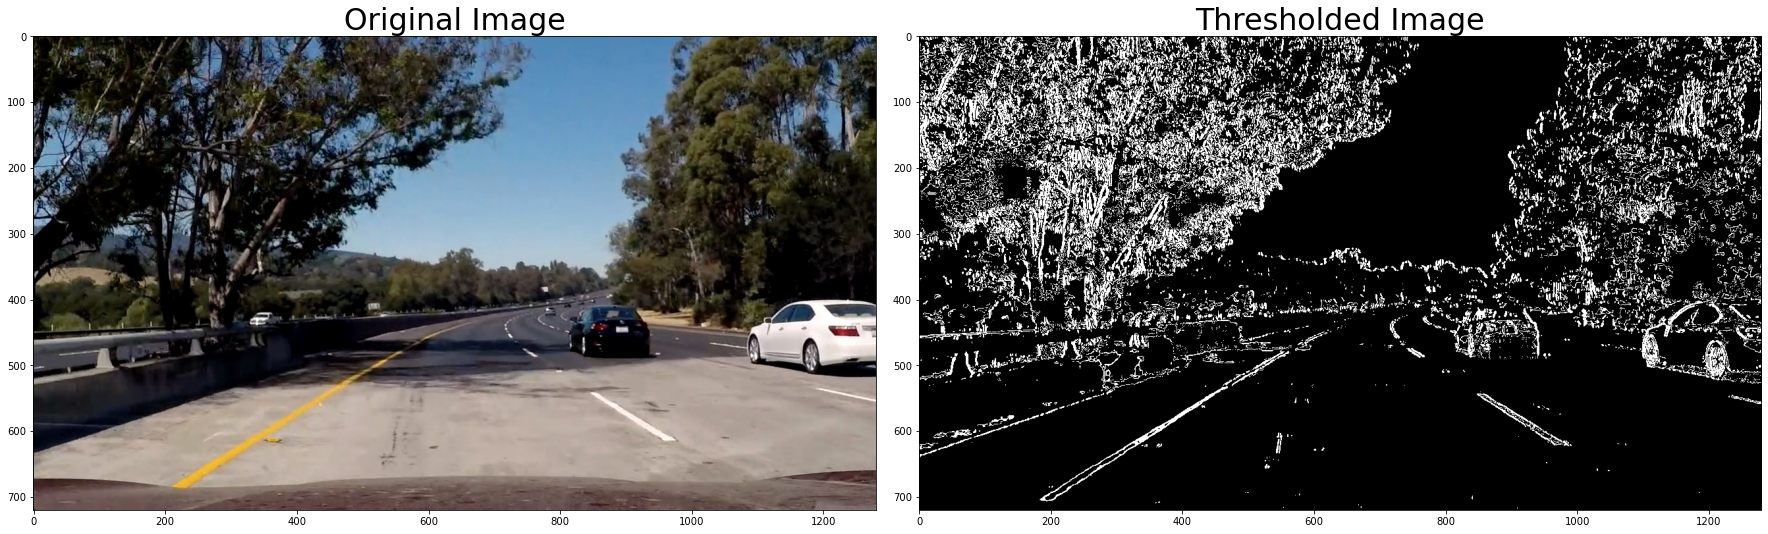

In [8]:
def test_thresholding_pipeline(raw_img):
    assert raw_img.shape[:2] == (default_height, default_width)
    img = cv2.undistort(raw_img, mtx, dist, None, mtx)
    gray_img_sobelx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=150)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = img_hls[:,:,2]
    sat_binary = binary_thresh(S, thresh_min=170, thresh_max=210)
    gray_img_sobelmag = mag_thresh(S, sobel_kernel=9, mag_thresh=(125, 200))
    combined_binary = np.zeros_like(sat_binary)
    combined_binary[(sat_binary == 1) | (gray_img_sobelmag == 1) | (gray_img_sobelx == 1)] = 1
    return combined_binary

test_img = mpimage.imread(test_images[4])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_thresholding_pipeline(test_img), cmap="gray")
ax2.set_title('Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

We can try testing on a straight-line lane image as well

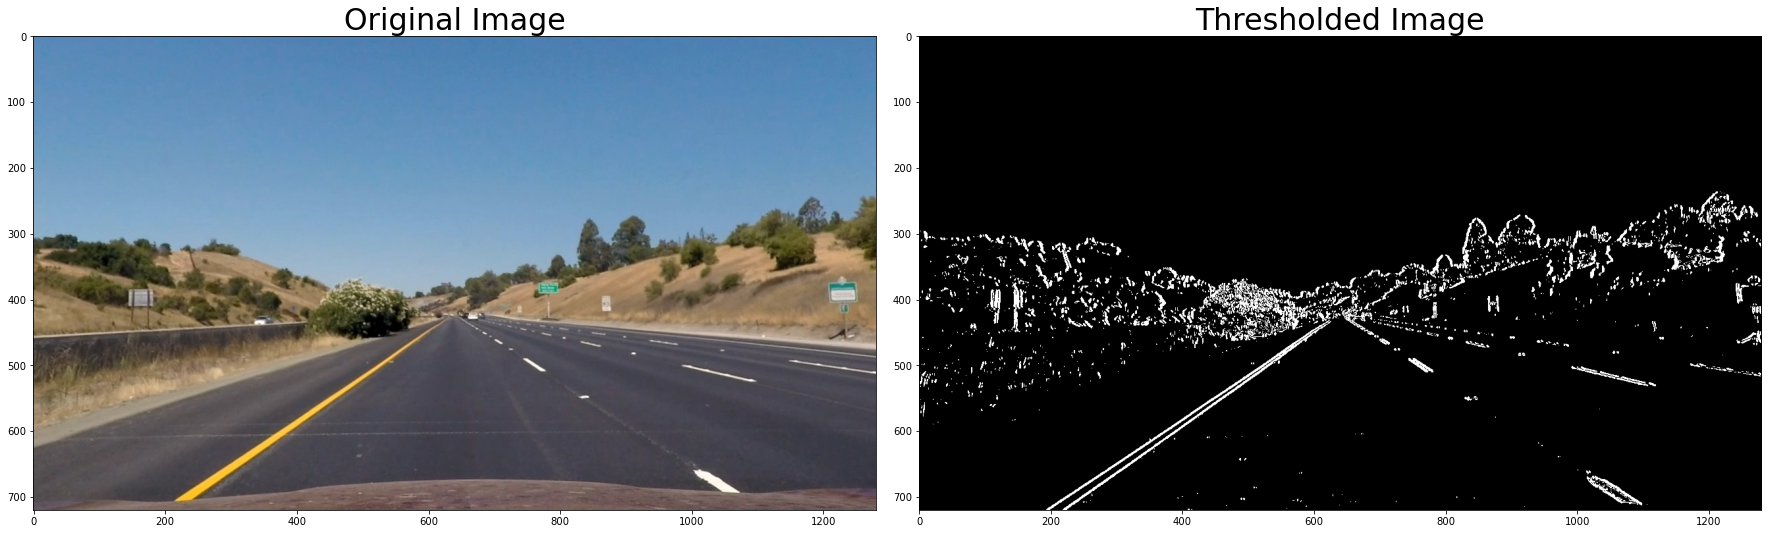

In [9]:
straight_line_test_images = [mpimage.imread(image) for image in glob.glob("test_images/straight_lines*.jpg")]
test_img = random.choice(straight_line_test_images)
test_img = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_thresholding_pipeline(test_img), cmap="gray")
ax2.set_title('Thresholded Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a perspective transform to rectify binary image

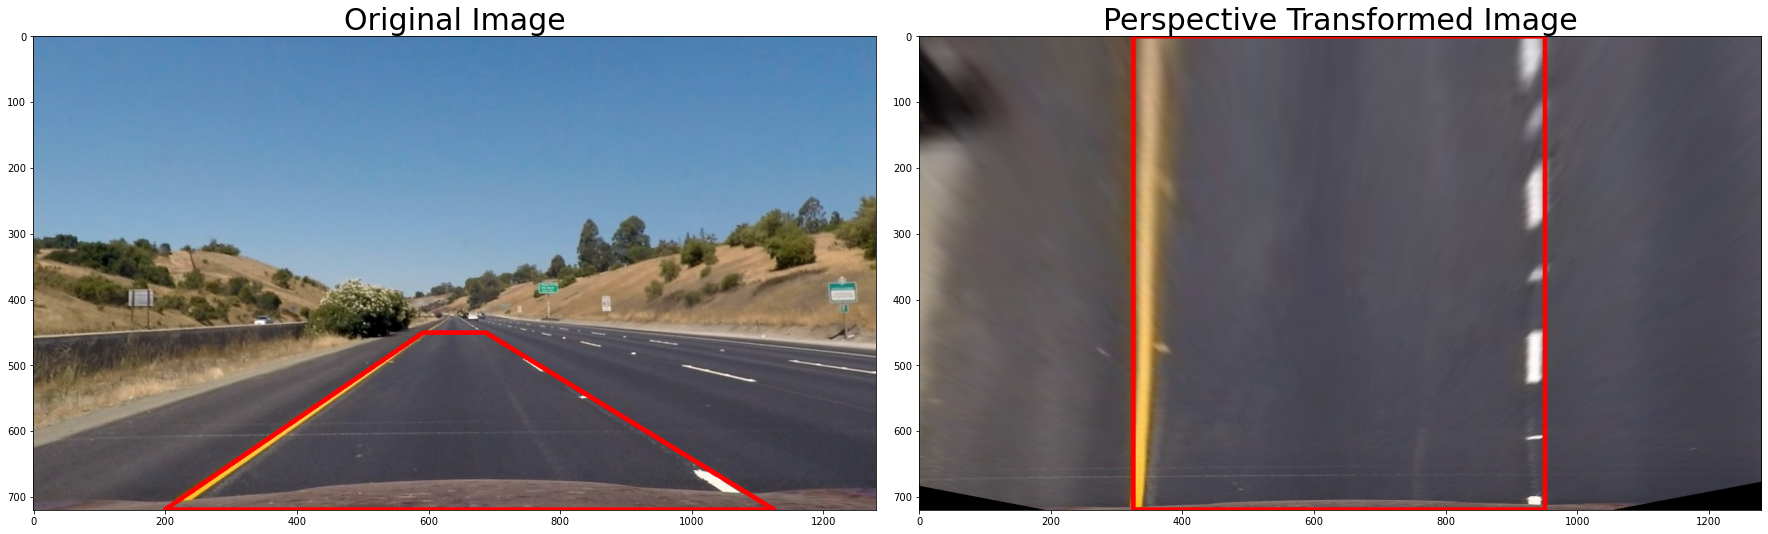

In [10]:
original_test_img = np.copy(test_img)
trap_pts = np.array([[200, 719], [592, 450], [687, 450], [1125, 719]], np.int32).reshape((-1,1,2))
square_pts = np.array([[325, 719], [325, 0], [950, 0], [950, 719]], np.int32).reshape((-1,1,2))

M = cv2.getPerspectiveTransform(np.float32(trap_pts.reshape((-1,2))), np.float32(square_pts.reshape((-1,2))))
warped_img = cv2.warpPerspective(original_test_img, M, original_test_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)

cv2.polylines(original_test_img,[trap_pts],True,(255,0,0), 5)
cv2.polylines(warped_img,[square_pts],True,(255,0,0), 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original_test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Perspective Transformed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now we can test the perspective transform on our binary image

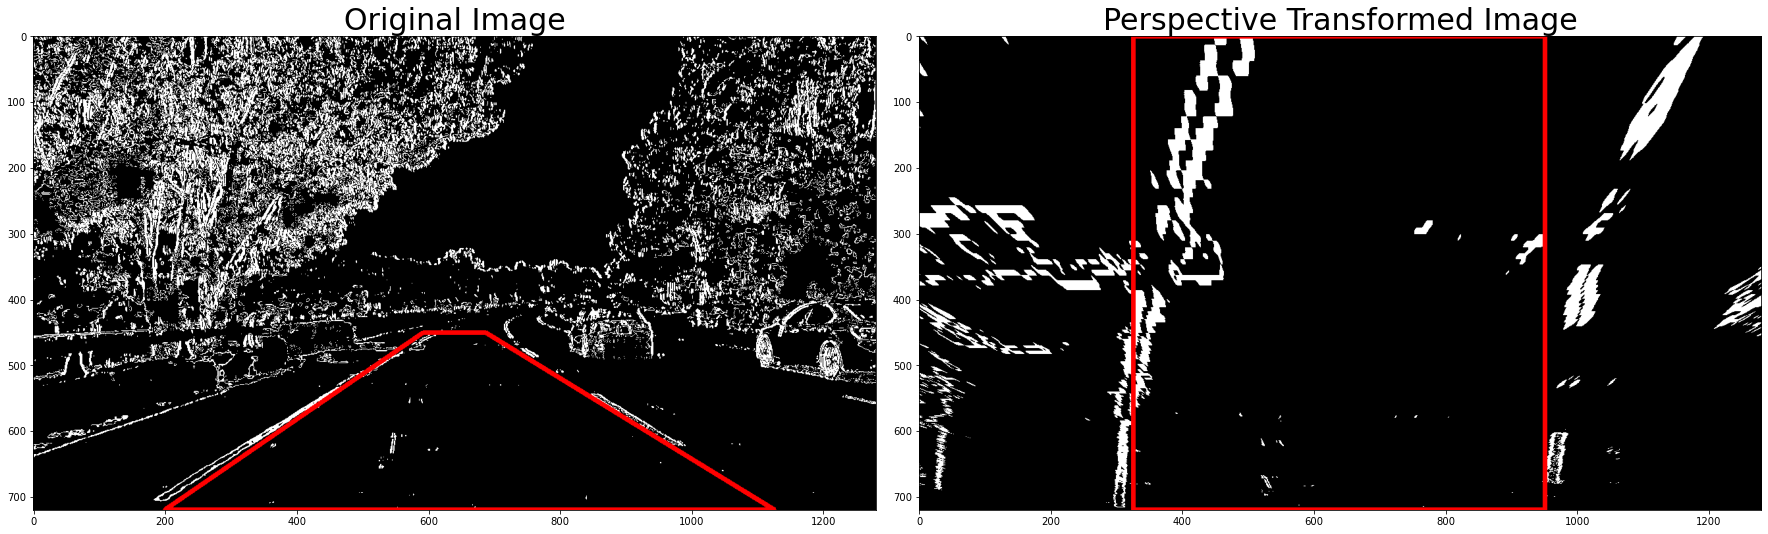

In [11]:
test_img = mpimage.imread(test_images[4])
thresholded_test_img = test_thresholding_pipeline(test_img)
M = cv2.getPerspectiveTransform(np.float32(trap_pts.reshape((-1,2))), np.float32(square_pts.reshape((-1,2))))
warped_img = cv2.warpPerspective(thresholded_test_img, M, thresholded_test_img.shape[:2][::-1], flags=cv2.INTER_LINEAR)

def convert_binary_to_color(binary_img):
    binary_img_cp = np.copy(binary_img)
    binary_img_cp[(binary_img == 1)] = 255
    return cv2.cvtColor(binary_img_cp, cv2.COLOR_GRAY2RGB)

thresholded_test_img_color = convert_binary_to_color(thresholded_test_img)
warped_img_color = convert_binary_to_color(warped_img)

cv2.polylines(thresholded_test_img_color,[trap_pts],True,(255,0,0), 5)
cv2.polylines(warped_img_color,[square_pts],True,(255,0,0), 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresholded_test_img_color)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_img_color)
ax2.set_title('Perspective Transformed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Detect lane pixels and fit to find the lane boundary

(311, 972)


Text(0.5, 1.0, 'Binary image with lane start points')

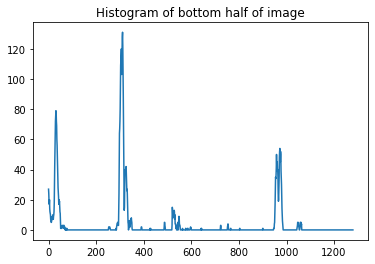

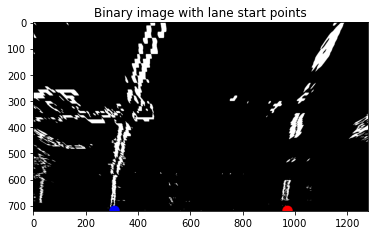

In [12]:
# to find the base of lanes, we can use a histogram and find the peaks
bottom_quarter = warped_img[3*warped_img.shape[0]//4:,:]
hist = np.sum(bottom_quarter, axis=0)
midpoint = warped_img.shape[1]//2
left_peak = np.argmax(hist[:midpoint])
right_peak = np.argmax(hist[midpoint:]) + midpoint
print((left_peak, right_peak))

fig, ax = plt.subplots()
ax.plot(hist)
ax.set_title("Histogram of bottom half of image")

fig, ax = plt.subplots()
warped_img_color = convert_binary_to_color(warped_img)
cv2.circle(warped_img_color, (left_peak, 719), 20, (0, 0, 255), -1)
cv2.circle(warped_img_color, (right_peak, 719), 20, (255, 0, 0), -1)
ax.imshow(warped_img_color)
ax.set_title("Binary image with lane start points")

## Sliding windows to find points on lane lines

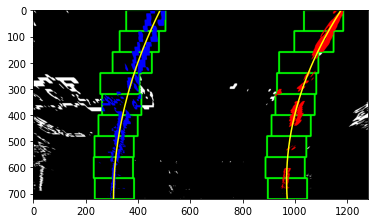

In [13]:
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 75
# Set minimum number of pixels found to recenter window
minpix = 50

# for visualizations
warped_img_color = convert_binary_to_color(warped_img)

window_height = np.int(warped_img.shape[0]//nwindows)

leftx_current = left_peak
rightx_current = right_peak

left_lane_pixels = []
right_lane_pixels = []
left_lane_points = []
right_lane_points = []

for nwindow in range(nwindows):
    left_win_top_right_x = leftx_current + margin
    left_win_top_right_y = warped_img.shape[0] - (nwindow + 1) * window_height
    left_win_bottom_left_x = leftx_current - margin
    left_win_bottom_left_y = warped_img.shape[0] - nwindow * window_height
    
    
    right_win_top_right_x = rightx_current + margin
    right_win_top_right_y = left_win_top_right_y
    right_win_bottom_left_x = rightx_current - margin
    right_win_bottom_left_y = left_win_bottom_left_y
    
    cv2.rectangle(warped_img_color, (left_win_bottom_left_x, left_win_bottom_left_y), (left_win_top_right_x, left_win_top_right_y), (0, 255, 0), 5)
    cv2.rectangle(warped_img_color, (right_win_bottom_left_x, right_win_bottom_left_y), (right_win_top_right_x, right_win_top_right_y), (0, 255, 0), 5)
    
    left_pix = warped_img[left_win_top_right_y:left_win_bottom_left_y, left_win_bottom_left_x:left_win_top_right_x].nonzero()
    left_lane_pixels.append(np.dstack((left_pix[1] + left_win_bottom_left_x, left_pix[0] + left_win_top_right_y)).squeeze())
    if(len(left_pix[1]) > minpix):
        leftx_current = left_win_bottom_left_x + int(np.mean(left_pix[1]))
        left_lane_points.append((leftx_current, (left_win_bottom_left_y + left_win_top_right_y)//2))
    right_pix = warped_img[right_win_top_right_y:right_win_bottom_left_y, right_win_bottom_left_x:right_win_top_right_x].nonzero()
    right_lane_pixels.append(np.dstack((right_pix[1] + right_win_bottom_left_x, right_pix[0] + right_win_top_right_y)).squeeze())
    if(len(right_pix[1]) > minpix):
        rightx_current = right_win_bottom_left_x + int(np.mean(right_pix[1]))
        right_lane_points.append((rightx_current, (right_win_bottom_left_y + right_win_top_right_y)//2))
    
left_lane_pixels = np.concatenate(left_lane_pixels)
right_lane_pixels = np.concatenate(right_lane_pixels)

warped_img_color[left_lane_pixels[:,1],left_lane_pixels[:,0]] = [0,0,255]
warped_img_color[right_lane_pixels[:,1],right_lane_pixels[:,0]] = [255,0,0]

left_lane_points = np.array(left_lane_points)
right_lane_points = np.array(right_lane_points)

left_line_fit = np.polyfit(left_lane_points[:,1], left_lane_points[:,0], 2)
right_lane_fit = np.polyfit(right_lane_points[:,1], right_lane_points[:,0], 2)

ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
left_fitx = left_line_fit[0]*ploty**2 + left_line_fit[1]*ploty + left_line_fit[2]
right_fitx = right_lane_fit[0]*ploty**2 + right_lane_fit[1]*ploty + right_lane_fit[2]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imshow(warped_img_color)

# Determine the curvature of the lane and vehicle position with respect to center

In [14]:
ym_per_pix = 30/warped_img.shape[0] # meters per pixel in y dimension
xm_per_pix = 3.7/(right_peak - left_peak) # meters per pixel in x dimension

def calculate_curvature(ploty, left_poly, right_poly, xm_per_pix, ym_per_pix):
    y_eval = np.max(ploty)
    
    left_fit_scaled = np.copy(left_poly)
    left_fit_scaled[0] *= xm_per_pix / (ym_per_pix ** 2)
    left_fit_scaled[1] *= xm_per_pix / ym_per_pix
    
    right_fit_scaled = np.copy(right_poly)
    right_fit_scaled[0] *= xm_per_pix / (ym_per_pix ** 2)
    right_fit_scaled[1] *= xm_per_pix / ym_per_pix
    
    left_curverad = ((1 + (2*left_fit_scaled[0]*y_eval*ym_per_pix + left_fit_scaled[1])**2)**1.5) / np.absolute(2*left_fit_scaled[0])
    right_curverad = ((1 + (2*right_fit_scaled[0]*y_eval*ym_per_pix + right_fit_scaled[1])**2)**1.5) / np.absolute(2*right_fit_scaled[0])
    return left_curverad, right_curverad

offset_in_meters = xm_per_pix * (((left_peak + right_peak) // 2) - warped_img.shape[1] // 2)
print(offset_in_meters)

left_curvature, right_curvature = calculate_curvature(ploty, left_line_fit, right_lane_fit, xm_per_pix, ym_per_pix)
print((left_curvature, right_curvature))

0.0055975794251134645
(452.87066092111604, 317.47010438503344)


# Warp the detected lane boundaries back onto the original image.

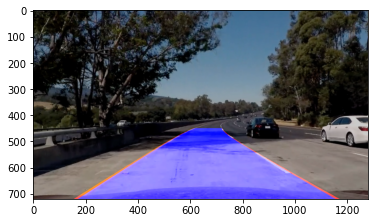

In [47]:
default_image = np.zeros((720, 1280, 3), dtype=np.float32)
left_lane_poly_points = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
right_lane_poly_points = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
cv2.polylines(default_image, [left_lane_poly_points], False, (255, 0, 0), 20)
cv2.polylines(default_image, [right_lane_poly_points], False, (255, 0, 0), 20)
cv2.fillPoly(default_image, [np.vstack([np.flip(left_lane_poly_points, 0), right_lane_poly_points])], (0, 0, 255))

M_inv = cv2.getPerspectiveTransform(np.float32(square_pts.reshape((-1,2))), np.float32(trap_pts.reshape((-1,2))))
unwarped_img = cv2.warpPerspective(default_image, M_inv, default_image.shape[:2][::-1], flags=cv2.INTER_LINEAR).astype(np.uint8)

test_img = mpimage.imread(test_images[4])
test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
output = cv2.addWeighted(test_img, 0.8, unwarped_img.astype(np.uint8), 1.0, 0)
plt.imshow(output)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

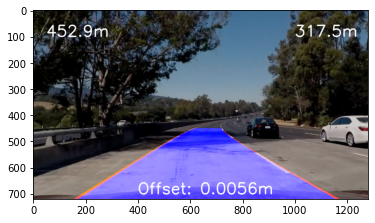

In [48]:
cv2.putText(output, "{0:.4g}m".format(left_curvature), (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)
cv2.putText(output, "{0:.4g}m".format(right_curvature), (1000, 100), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)
cv2.putText(output, "Offset: {0:.3g}m".format(offset_in_meters), (400, 700), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)
plt.imshow(output)

# Create full pipeline

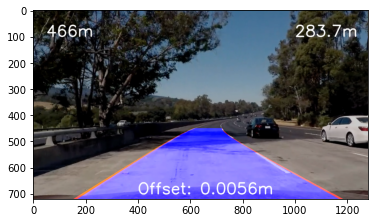

In [82]:
def advanced_lane_finding_pipeline(input_frame, shape=(720, 1280)):
    try:
        assert input_frame.shape[:2] == shape
        undistorted_img = cv2.undistort(input_frame, mtx, dist, None, mtx)
        gray_img_sobelx = abs_sobel_thresh(undistorted_img, orient='x', thresh_min=20, thresh_max=150)
        img_hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
        S = img_hls[:,:,2]
        sat_binary = binary_thresh(S, thresh_min=170, thresh_max=210)
        gray_img_sobelmag = mag_thresh(S, sobel_kernel=9, mag_thresh=(125, 200))
        combined_binary = np.zeros_like(sat_binary)
        combined_binary[(sat_binary == 1) | (gray_img_sobelmag == 1) | (gray_img_sobelx == 1)] = 1

        trap_pts = np.array([[200, 719], [592, 450], [687, 450], [1125, 719]], np.int32).reshape((-1,1,2))
        square_pts = np.array([[325, 719], [325, 0], [950, 0], [950, 719]], np.int32).reshape((-1,1,2))
        M = cv2.getPerspectiveTransform(np.float32(trap_pts.reshape((-1,2))), np.float32(square_pts.reshape((-1,2))))
        warped_img = cv2.warpPerspective(combined_binary, M, combined_binary.shape[:2][::-1], flags=cv2.INTER_LINEAR)


        bottom_quarter = warped_img[3*warped_img.shape[0]//4:,:]
        hist = np.sum(bottom_quarter, axis=0)
        midpoint = warped_img.shape[1]//2
        left_peak = np.argmax(hist[:midpoint])
        right_peak = np.argmax(hist[midpoint:]) + midpoint

        nwindows = 9
        margin = 100
        minpix = 50

        warped_img_color = convert_binary_to_color(warped_img)

        window_height = np.int(warped_img.shape[0]//nwindows)

        leftx_current = left_peak
        rightx_current = right_peak

        left_lane_pixels = []
        right_lane_pixels = []
        left_lane_points = []
        right_lane_points = []

        for nwindow in range(nwindows):
            left_win_top_right_x = leftx_current + margin
            left_win_top_right_y = warped_img.shape[0] - (nwindow + 1) * window_height
            left_win_bottom_left_x = max(0, leftx_current - margin)
            left_win_bottom_left_y = warped_img.shape[0] - nwindow * window_height

            right_win_top_right_x = min(shape[1] - 1, rightx_current + margin)
            right_win_top_right_y = left_win_top_right_y
            right_win_bottom_left_x = rightx_current - margin
            right_win_bottom_left_y = left_win_bottom_left_y

            cv2.rectangle(warped_img_color, (left_win_bottom_left_x, left_win_bottom_left_y), (left_win_top_right_x, left_win_top_right_y), (0, 255, 0), 5)
            cv2.rectangle(warped_img_color, (right_win_bottom_left_x, right_win_bottom_left_y), (right_win_top_right_x, right_win_top_right_y), (0, 255, 0), 5)

            left_pix = warped_img[left_win_top_right_y:left_win_bottom_left_y, left_win_bottom_left_x:left_win_top_right_x].nonzero()
            left_lane_pixels.append(np.dstack((left_pix[1] + left_win_bottom_left_x, left_pix[0] + left_win_top_right_y)).squeeze())
            if(len(left_pix[1]) > minpix):
                leftx_current = left_win_bottom_left_x + int(np.mean(left_pix[1]))
                left_lane_points.append((leftx_current, (left_win_bottom_left_y + left_win_top_right_y)//2))
            right_pix = warped_img[right_win_top_right_y:right_win_bottom_left_y, right_win_bottom_left_x:right_win_top_right_x].nonzero()
            right_lane_pixels.append(np.dstack((right_pix[1] + right_win_bottom_left_x, right_pix[0] + right_win_top_right_y)).squeeze())
            if(len(right_pix[1]) > minpix):
                rightx_current = right_win_bottom_left_x + int(np.mean(right_pix[1]))
                right_lane_points.append((rightx_current, (right_win_bottom_left_y + right_win_top_right_y)//2))

        left_lane_pixels = np.concatenate(left_lane_pixels)
        right_lane_pixels = np.concatenate(right_lane_pixels)

        left_lane_points = np.array(left_lane_points)
        right_lane_points = np.array(right_lane_points)

        left_line_fit = np.polyfit(left_lane_points[:,1], left_lane_points[:,0], 2)
        right_lane_fit = np.polyfit(right_lane_points[:,1], right_lane_points[:,0], 2)

        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        left_fitx = left_line_fit[0]*ploty**2 + left_line_fit[1]*ploty + left_line_fit[2]
        right_fitx = right_lane_fit[0]*ploty**2 + right_lane_fit[1]*ploty + right_lane_fit[2]

        ym_per_pix = 30/warped_img.shape[0] # meters per pixel in y dimension
        xm_per_pix = 3.7/(right_peak - left_peak) # meters per pixel in x dimension

        def calculate_curvature(ploty, left_poly, right_poly, xm_per_pix, ym_per_pix):
            y_eval = np.max(ploty)

            left_fit_scaled = np.copy(left_poly)
            left_fit_scaled[0] *= xm_per_pix / (ym_per_pix ** 2)
            left_fit_scaled[1] *= xm_per_pix / ym_per_pix

            right_fit_scaled = np.copy(right_poly)
            right_fit_scaled[0] *= xm_per_pix / (ym_per_pix ** 2)
            right_fit_scaled[1] *= xm_per_pix / ym_per_pix

            left_curverad = ((1 + (2*left_fit_scaled[0]*y_eval*ym_per_pix + left_fit_scaled[1])**2)**1.5) / np.absolute(2*left_fit_scaled[0])
            right_curverad = ((1 + (2*right_fit_scaled[0]*y_eval*ym_per_pix + right_fit_scaled[1])**2)**1.5) / np.absolute(2*right_fit_scaled[0])
            return left_curverad, right_curverad

        offset_in_meters = xm_per_pix * (((left_peak + right_peak) // 2) - warped_img.shape[1] // 2)
        left_curvature, right_curvature = calculate_curvature(ploty, left_line_fit, right_lane_fit, xm_per_pix, ym_per_pix)

        default_image = np.zeros((720, 1280, 3), dtype=np.float32)
        left_lane_poly_points = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
        right_lane_poly_points = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
        cv2.polylines(default_image, [left_lane_poly_points], False, (255, 0, 0), 20)
        cv2.polylines(default_image, [right_lane_poly_points], False, (255, 0, 0), 20)
        cv2.fillPoly(default_image, [np.vstack([np.flip(left_lane_poly_points, 0), right_lane_poly_points])], (0, 0, 255))

        M_inv = cv2.getPerspectiveTransform(np.float32(square_pts.reshape((-1,2))), np.float32(trap_pts.reshape((-1,2))))
        unwarped_img = cv2.warpPerspective(default_image, M_inv, default_image.shape[:2][::-1], flags=cv2.INTER_LINEAR).astype(np.uint8)

        output = cv2.addWeighted(undistorted_img, 0.8, unwarped_img.astype(np.uint8), 1.0, 0)

        cv2.putText(output, "{0:.4g}m".format(left_curvature), (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)
        cv2.putText(output, "{0:.4g}m".format(right_curvature), (1000, 100), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)
        cv2.putText(output, "Offset: {0:.3g}m".format(offset_in_meters), (400, 700), cv2.FONT_HERSHEY_SIMPLEX , 2, (255, 255, 255), 3, cv2.LINE_AA)

        return output
    except:
        return undistorted_img

output_frame = advanced_lane_finding_pipeline(mpimage.imread(test_images[4]))
plt.imshow(output_frame)

# Test on an actual video

In [85]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_filename = "test_videos/challenge_video.mp4"
output_filename = "output_videos/challenge_video.mp4"

clip = VideoFileClip(input_filename)
output_clip = clip.fl_image(advanced_lane_finding_pipeline) 
%time output_clip.write_videofile(output_filename, audio=False)

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
Wall time: 1min 57s
